In [26]:
! mkdir ./data
! mkdir ./data/all
! git clone https://github.com/encharm/Font-Awesome-SVG-PNG
! cp Font-Awesome-SVG-PNG/black/png/16/* ./data/all

import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
def show_as_image(binary_image, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(binary_image, cmap='gray')
    plt.xticks([]); plt.yticks([])

%matplotlib inline



mkdir: cannot create directory ‘./data’: File exists
mkdir: cannot create directory ‘./data/all’: File exists
fatal: destination path 'Font-Awesome-SVG-PNG' already exists and is not an empty directory.


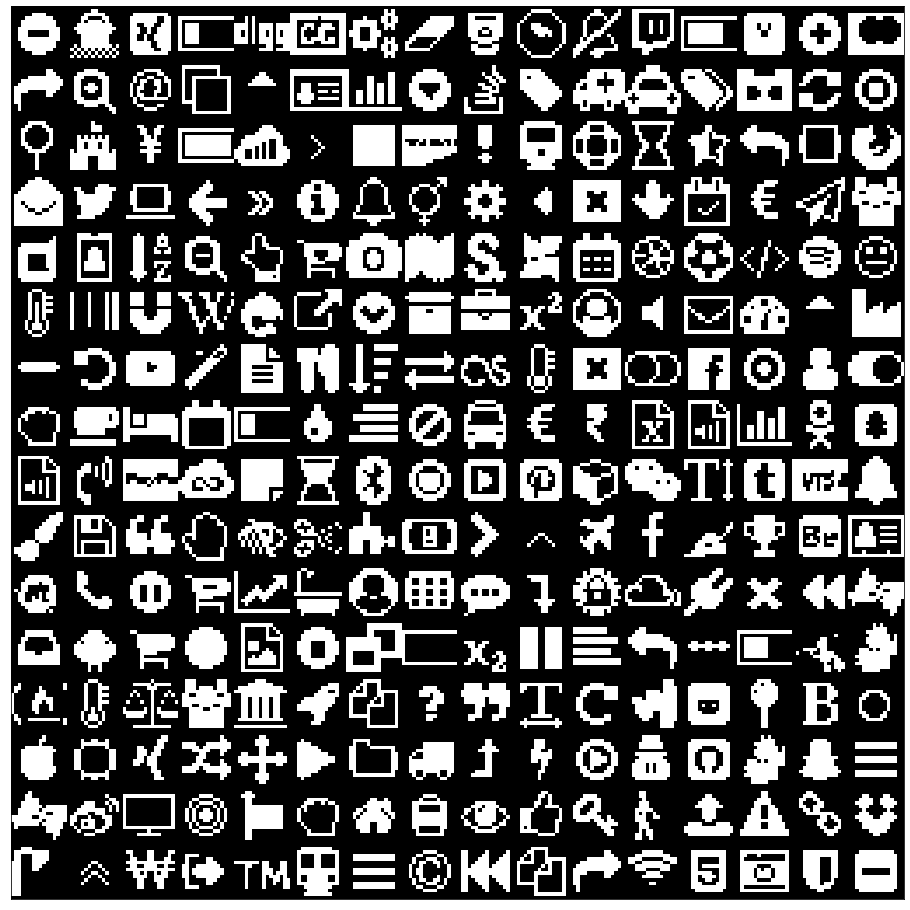

In [5]:


la_loader = lambda _: Image.open(_).convert('LA')

image_dataset = datasets.folder.ImageFolder(
    './data', 
    transform=transforms.Lambda(lambda image: transforms.ToTensor()(image.crop(box=(0, 0, 16, 16)))[1:, :, :] > .5),
    loader=la_loader)

batch_images, labels = next(b for b in DataLoader(image_dataset, sampler=RandomSampler(image_dataset), batch_size=256))

def batch_images_to_one(batches_images):
    n_square_elements = int(np.sqrt(batches_images.shape[0]))
    rows_images = np.split(np.squeeze(batches_images), n_square_elements)
    return np.vstack([np.hstack(row_images) for row_images in rows_images])

show_as_image(batch_images_to_one(batch_images.numpy()), figsize=(16, 17))

In [0]:



class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)
    
class PixelCNN(nn.Module):
    n_channels = 32
    kernel_size = 7
    padding = 3
    n_pixels_out = 2 # binary 0/1 pixels

    def __init__(self):
        super(PixelCNN, self).__init__()
        self.layers = nn.Sequential(
            MaskedConv2d('A', in_channels=1, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_pixels_out, kernel_size=1)
        )

    def forward(self, x):
        pixel_logits = self.layers(x)
        return pixel_logits

In [0]:
def xp():
    import torch.nn.functional as F
    from torch.utils.data.sampler import SubsetRandomSampler


    N_EPOCHS = 80
    BATCH_SIZE = 128
    LR = 0.005
    TEST_RATIO = .2

    cnn = PixelCNN()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)

    test_indices = np.random.choice(len(image_dataset), size=int(len(image_dataset) * TEST_RATIO), replace=False)
    train_indices = np.setdiff1d(np.arange(len(image_dataset)), test_indices)
    train_loader = DataLoader(image_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(indices=train_indices))
    test_loader = DataLoader(image_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(indices=test_indices))

    for epoch in range(N_EPOCHS):
        for i, (images, _) in enumerate(train_loader):
            images = Variable(images).float()
            optimizer.zero_grad()
            loss = F.cross_entropy(input=cnn(images), target=torch.squeeze(images).long())
            loss.backward()
            optimizer.step()
            
        test_images = Variable(next(i for i, _ in test_loader)).float()
        test_loss =F .cross_entropy(input=cnn(test_images), target=torch.squeeze(test_images).long())

        if epoch%5:
            print ('Epoch [%d/%d], Train loss: %.4f, Test loss: %.4f'
                %(epoch+1, N_EPOCHS, loss.item(), test_loss.item()))
        
    return cnn

In [16]:
cnn = xp()

Epoch [1/80], Train loss: 0.6058, Test loss: 0.5727
Epoch [2/80], Train loss: 0.5327, Test loss: 0.5118
Epoch [3/80], Train loss: 0.5121, Test loss: 0.4954
Epoch [4/80], Train loss: 0.5173, Test loss: 0.4815
Epoch [5/80], Train loss: 0.4988, Test loss: 0.4808
Epoch [6/80], Train loss: 0.5105, Test loss: 0.4780
Epoch [7/80], Train loss: 0.4959, Test loss: 0.4795
Epoch [8/80], Train loss: 0.5005, Test loss: 0.4773
Epoch [9/80], Train loss: 0.4889, Test loss: 0.4764
Epoch [10/80], Train loss: 0.5005, Test loss: 0.4717
Epoch [11/80], Train loss: 0.4883, Test loss: 0.4669
Epoch [12/80], Train loss: 0.4854, Test loss: 0.4645
Epoch [13/80], Train loss: 0.4736, Test loss: 0.4552
Epoch [14/80], Train loss: 0.4651, Test loss: 0.4457
Epoch [15/80], Train loss: 0.4598, Test loss: 0.4386
Epoch [16/80], Train loss: 0.4275, Test loss: 0.4245
Epoch [17/80], Train loss: 0.4235, Test loss: 0.3995
Epoch [18/80], Train loss: 0.3857, Test loss: 0.3715
Epoch [19/80], Train loss: 0.3600, Test loss: 0.3483
Ep

In [0]:
def generate_samples(n_samples=12, starting_point=(0, 0), starting_image=None):

    samples = torch.from_numpy(
        starting_image if starting_image is not None else np.zeros((n_samples * n_samples, 1, IMAGE_WIDTH, IMAGE_HEIGHT))).float()

    cnn.train(False)

    for i in range(IMAGE_WIDTH):
        for j in range(IMAGE_HEIGHT):
            if i < starting_point[0] or (i == starting_point[0] and j < starting_point[1]):
                continue
            out = cnn(Variable(samples, volatile=True))
            probs = F.softmax(out[:, :, i, j]).data
            samples[:, :, i, j] = torch.multinomial(probs, 1).float()
    return samples.numpy()

In [0]:
test_indices = np.random.choice(len(image_dataset), size=int(len(image_dataset) * 0.2), replace=False)
train_indices = np.setdiff1d(np.arange(len(image_dataset)), test_indices)
train_loader = DataLoader(image_dataset, batch_size=128, sampler=SubsetRandomSampler(indices=train_indices))
test_loader = DataLoader(image_dataset, batch_size=128, sampler=SubsetRandomSampler(indices=test_indices))
IMAGE_WIDTH, IMAGE_HEIGHT = 16, 16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


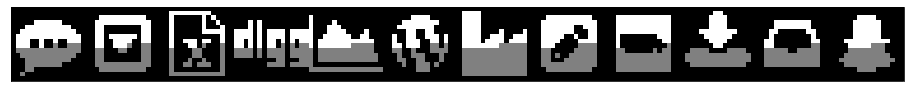

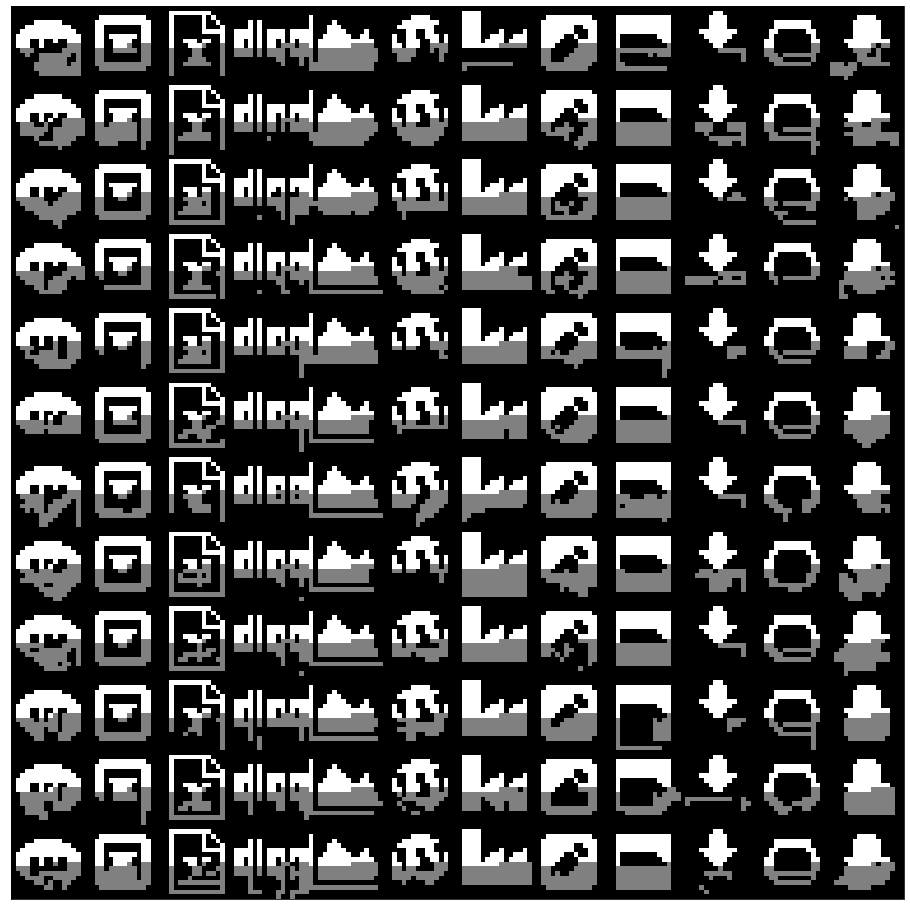

In [27]:
n_images = 12
batch_images, labels = next(b for b in train_loader)
batch_images = batch_images[:n_images, :, :, :]
starting_point = (8, 8)
row_grid, col_grid = np.meshgrid(np.arange(IMAGE_WIDTH), np.arange(IMAGE_HEIGHT), indexing='ij')
mask = np.logical_or(row_grid < starting_point[0], np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1]))

starting_images = batch_images.numpy().squeeze()
batch_starting_images = np.expand_dims(np.stack([i * mask for i in starting_images] * n_images), axis=1)

samples = generate_samples(starting_image=batch_starting_images, starting_point=starting_point)

show_as_image(np.hstack([(1 + mask) * i for i in starting_images]), figsize=(16, 17))

show_as_image( batch_images_to_one((samples * (1 + mask))), figsize=(16, 17))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


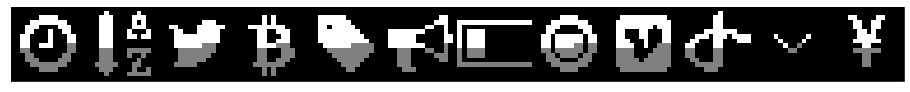

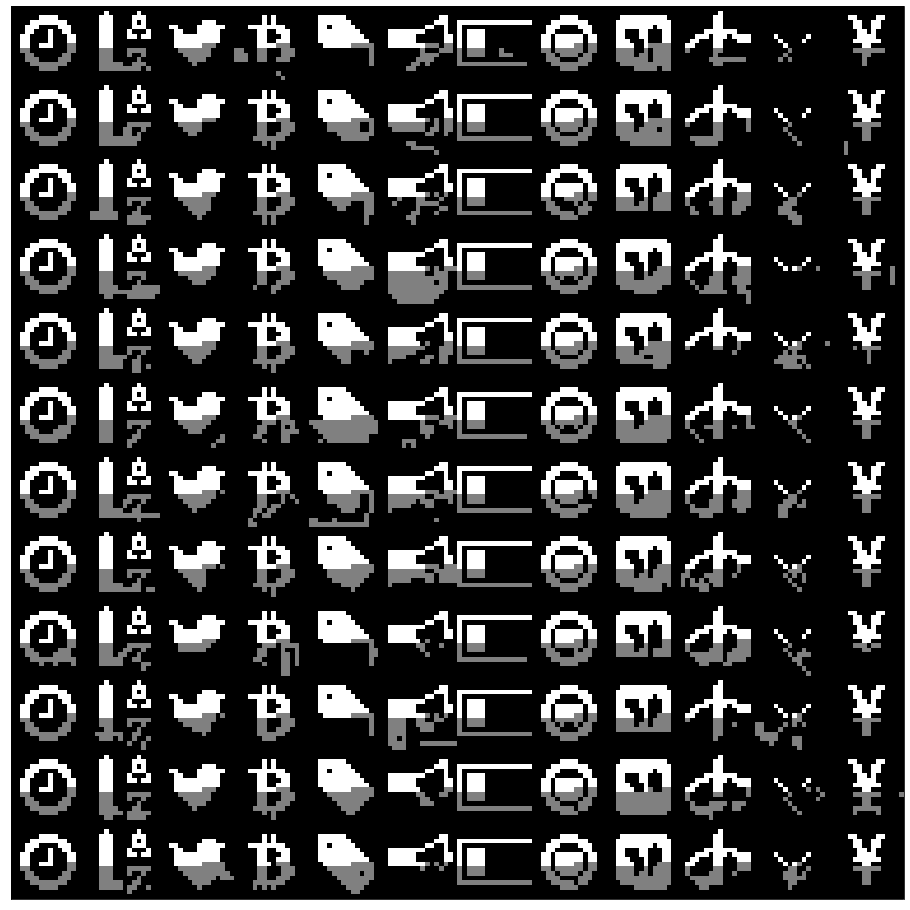

In [28]:

n_images = 12
batch_images, labels = next(b for b in test_loader)
batch_images = batch_images[:n_images, :, :, :]

starting_point = (8, 8)

row_grid, col_grid = np.meshgrid(np.arange(IMAGE_WIDTH), np.arange(IMAGE_HEIGHT), indexing='ij')
mask = np.logical_or(row_grid < starting_point[0], np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1]))

starting_images = batch_images.numpy().squeeze()
batch_starting_images = np.expand_dims(np.stack([i * mask for i in starting_images] * n_images), axis=1)

samples = generate_samples(starting_image=batch_starting_images, starting_point=starting_point)

show_as_image(np.hstack([(1 + mask) * i for i in starting_images]), figsize=(16, 17))

show_as_image(
    batch_images_to_one((samples * (1 + mask))),
    figsize=(16, 17))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


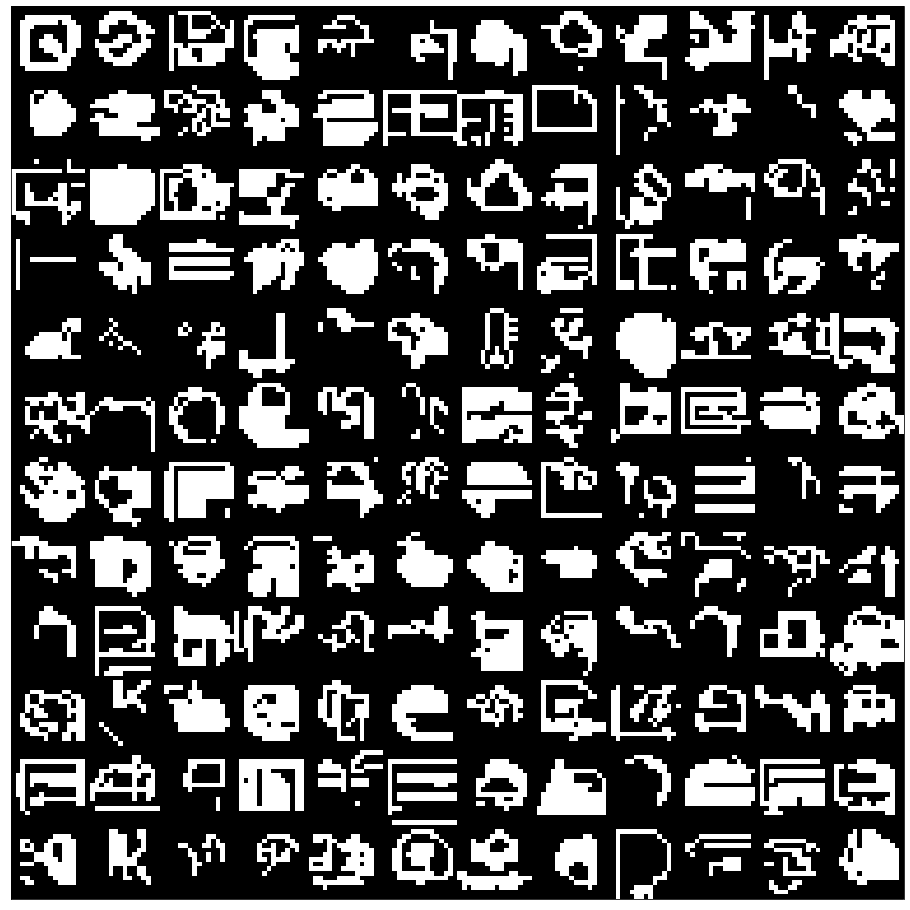

In [29]:
samples = generate_samples(12)

show_as_image(
    batch_images_to_one(samples),
    figsize=(16, 17))